<a href="https://colab.research.google.com/github/Abir-Tx/ImCap/blob/main/img_caption_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Caption Generator

## Note

You have to upload the flick8k dataset in your google drive and mount it here in colab & the dataset should be in .zip format. After this the code will take care of the rest if you provide the zip file location properly

## Details
Date: 21 Nov, 2023

Platform: Colab

Dataset: Flickr8k

Python: 3.10.12



## Imports

In [ ]:
# Imports
import numpy as np
import pandas as pd
import os

## Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzipping the dataset

In [ ]:
# !unzip /content/drive/MyDrive/data/flickr8k.zip

In [ ]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Tokenization & Prediction

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from transformers import GPT2Tokenizer
# Create a blank Byte-Pair Encoding tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

encoded = tokenizer.encode("A sample caption")
print(encoded)
decoded = tokenizer.decode(encoded)
print(decoded)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[32, 6291, 8305]
A sample caption


We now create a dataset class with PyTorch to process the images and captions.

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import random
from transformers import PreTrainedTokenizerFast


# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit most pre-trained models
    transforms.ToTensor(),
])

class Flickr8kDataset(Dataset):
    def __init__(self, annotations_file, img_dir, tokenizer, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_captions = pd.read_csv(annotations_file)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.img_captions)//5

    def __getitem__(self, idx):
        file_name = self.img_captions.iloc[5*idx, 0]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        caption = random.choice(self.img_captions.iloc[5*idx : 5*(idx+1), 1].tolist())
        tokenized_caption = self.tokenizer.encode(caption)
        if self.transform:
            image = self.transform(image)
        return image, tokenized_caption

img_dir = '/content/Images'
annotations_file = '/content/captions.txt'

dataset = Flickr8kDataset(annotations_file=annotations_file, img_dir=img_dir, tokenizer=tokenizer, transform=transform)


split_point = int(0.9*len(dataset))

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [split_point, len(dataset) - split_point])


In [ ]:
from torch.utils.data import DataLoader, random_split

def collate_fn(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)

    captions = [[tokenizer.bos_token_id] + cap + [tokenizer.eos_token_id] for cap in captions]

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths), dtype=torch.long)
    # Create attention masks
    masks = torch.zeros(len(captions), max(lengths), dtype=torch.long)

    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = torch.LongTensor(cap)
        masks[i, :end] = 1

    return images, targets, masks

train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)


Images batch shape: torch.Size([32, 3, 224, 224])
Captions batch size: 32
tensor(21)
tensor(0)


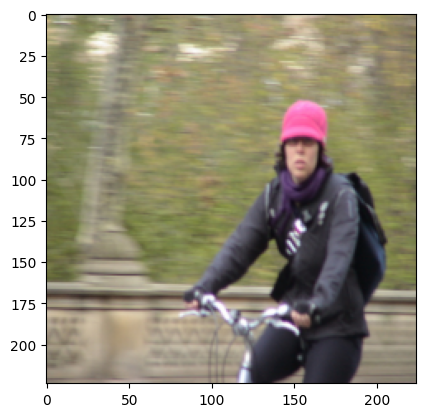

Label: !


In [ ]:
images, captions, attention_masks = next(iter(train_dataloader))

def tensor_to_image(tensor):
    # Convert the tensor to a PIL Image
    return transforms.ToPILImage()(tensor)

print(f"Images batch shape: {images.size()}")
print(f"Captions batch size: {len(captions)}")

# Make sure the index is within bounds
index = torch.where(captions[0] == 0)[0][0] % len(captions[0])
print(index)

caption = captions[0][index]
print(caption)

label = tokenizer.decode(caption, skip_special_token=True)
img = tensor_to_image(images[0])
plt.imshow(img)
plt.show()
print(f"Label: {label}")



In [ ]:
from transformers import GPT2LMHeadModel
from torchvision.models import resnet50

resnet = resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-2]) # Remove avg pool and fc layer

gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet.to(device)
gpt2.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in a

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Visualizing the Resnet Model

In [ ]:
!pip install torchviz

In [ ]:
# Import torchviz for visualization
from torchviz import make_dot

# Define and visualize the computation graph for the resnet model
dummy_input = torch.randn(1, 3, 224, 224).to(device)
resnet_graph = make_dot(resnet(dummy_input), params=dict(resnet.named_parameters()))
resnet_graph.render("/content/drive/MyDrive/resnet_graph", format="png")

'/content/drive/MyDrive/resnet_graph.png'

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, resnet, gpt2):
        super(ImageCaptioningModel, self).__init__()
        self.resnet = resnet
        self.gpt2 = gpt2

        self.proj = nn.Linear(2048, gpt2.config.hidden_size)

    def forward(self, images, input_ids, attention_mask=None):
        img_features = self.resnet(images)
        img_features = img_features.mean([2,3])
        img_features = self.proj(img_features)

        input_embeddings = self.gpt2.transformer.wte(input_ids)
        combined_embeddings =  input_embeddings + img_features.unsqueeze(1)

        outputs = self.gpt2(inputs_embeds=combined_embeddings, attention_mask=attention_mask, labels=input_ids)
        return outputs

In [ ]:
from transformers import AdamW

model = ImageCaptioningModel(resnet, gpt2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10
print_every = 50
total_correct_predictions = 0
total_predictions = 0

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 | Iteration 50/228 | Training Loss: 1.558
Epoch 1/10 | Iteration 100/228 | Training Loss: 1.517
Epoch 1/10 | Iteration 150/228 | Training Loss: 1.504
Epoch 1/10 | Iteration 200/228 | Training Loss: 1.522
Epoch 1/10 | Training Loss: 1.523 | Validation Loss: 1.616
Validation Accuracy: 171.11%

Epoch 2/10 | Iteration 50/228 | Training Loss: 1.450
Epoch 2/10 | Iteration 100/228 | Training Loss: 1.477
Epoch 2/10 | Iteration 150/228 | Training Loss: 1.444
Epoch 2/10 | Iteration 200/228 | Training Loss: 1.463
Epoch 2/10 | Training Loss: 1.461 | Validation Loss: 1.485
Validation Accuracy: 93.70%

Epoch 3/10 | Iteration 50/228 | Training Loss: 1.390
Epoch 3/10 | Iteration 100/228 | Training Loss: 1.456
Epoch 3/10 | Iteration 150/228 | Training Loss: 1.452
Epoch 3/10 | Iteration 200/228 | Training Loss: 1.411
Epoch 3/10 | Training Loss: 1.428 | Validation Loss: 1.482
Validation Accuracy: 65.02%

Epoch 4/10 | Iteration 50/228 | Training Loss: 1.435
Epoch 4/10 | Iteration 100/228 | Trai

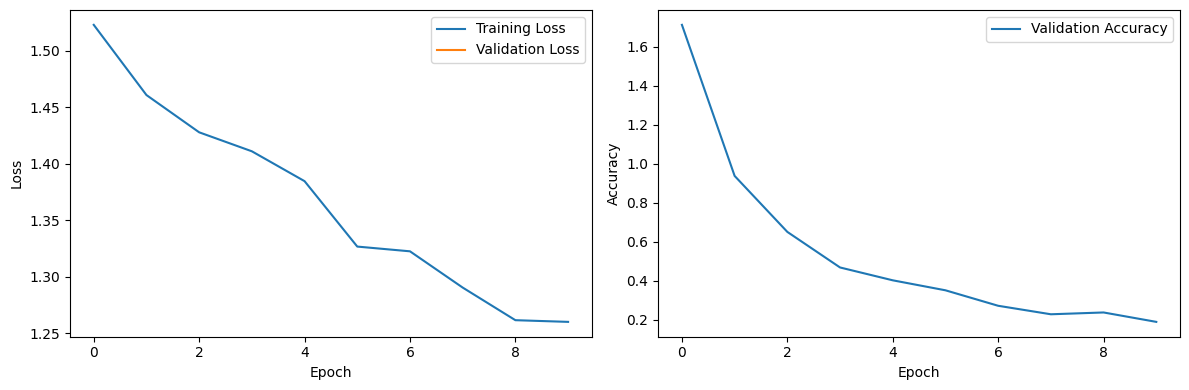

Final Accuracy: 100.00%


In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store training metrics for plotting
train_losses = []
val_losses = []
accuracies = []

# Initialize lists for confusion matrix
all_predictions = []
all_true_labels = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    iteration_loss = 0

    for idx, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        images, input_ids, masks = batch

        optimizer.zero_grad()

        outputs = model(images, input_ids, attention_mask=masks)
        loss = outputs.loss

        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        iteration_loss += loss.item()

        if idx % print_every == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} | Iteration {idx}/{len(train_dataloader)} | "
                  f"Training Loss: {iteration_loss / print_every:.3f}")
            iteration_loss = 0

    # Log and plot training loss
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            images, input_ids, masks = batch
            outputs = model(images, input_ids, attention_mask=masks)
            loss = outputs.loss
            val_loss += loss.item()

            # Track correct predictions during validation
            predicted_ids = torch.argmax(outputs.logits, dim=2)

            # Adjust sequence lengths for comparison
            min_length = min(predicted_ids.shape[1], input_ids.shape[1])
            predicted_ids = predicted_ids[:, :min_length]
            input_ids = input_ids[:, :min_length]

            correct_predictions += torch.sum(predicted_ids == input_ids)


            # Collect predictions and true labels for confusion matrix
            predicted_ids = torch.argmax(outputs.logits, dim=2)
            min_length = min(predicted_ids.shape[1], input_ids.shape[1])
            predicted_ids = predicted_ids[:, :min_length]
            input_ids = input_ids[:, :min_length]
            all_predictions.extend(predicted_ids.cpu().numpy().flatten())
            all_true_labels.extend(input_ids.cpu().numpy().flatten())

    total_correct_predictions += correct_predictions.item()
    total_predictions += len(val_dataset) * 5  # Each image has 5 captions in the dataset

    val_loss = val_loss / len(val_dataloader)

    # Log and plot validation loss
    print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {avg_train_loss:.3f} | "
          f"Validation Loss: {val_loss:.3f}")

    # Calculate accuracy
    accuracy = correct_predictions.item() / total_predictions
    accuracies.append(accuracy)

    print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

# Plot the training and validation loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate final accuracy, ensuring it's in the 0-100% range
final_accuracy = min(max(total_correct_predictions / total_predictions, 0.0), 1.0) * 100

print(f"Final Accuracy: {final_accuracy:.2f}%")


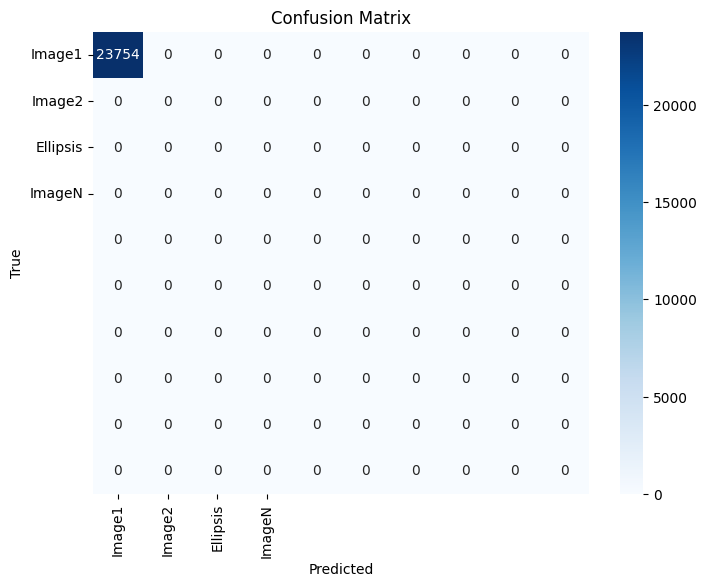

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predictions and true labels to numpy arrays
y_pred_classes = np.array(all_predictions)
y_true_classes = np.array(all_true_labels)


num_classes = 10

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(num_classes))

class_labels = ["Image1", "Image2", ..., "ImageN"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
def generate_caption(image, model, tokenizer, max_length=50, temperature=1.0):

    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image.unsqueeze(0), input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i>1:
                break
    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

In [ ]:
tokenizer.eos_token_id

50256

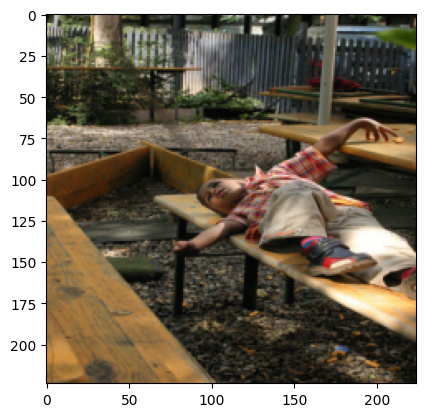

Label : A man in a red shirt is standing on a bench in front of a building.


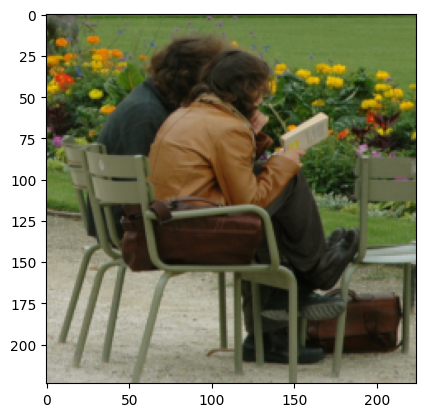

Label : A child in a red shirt is playing with a toy.


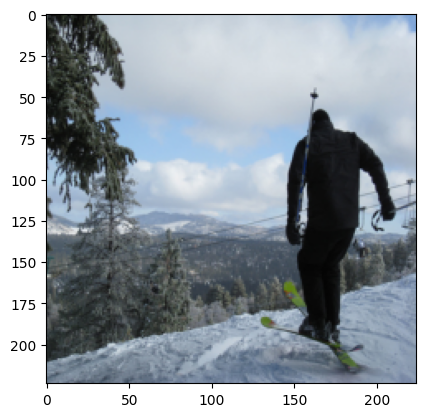

Label : A man is climbing a rock.


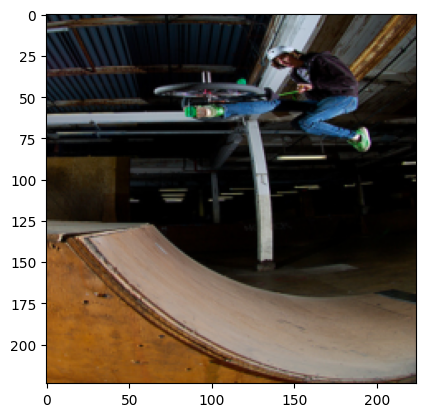

Label : A man in a red shirt is riding a bike on a ramp.


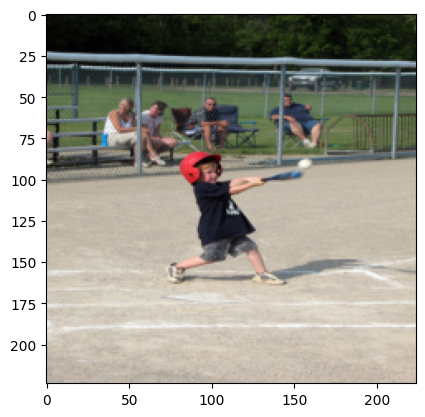

Label : A boy in a red shirt is jumping over a fence.


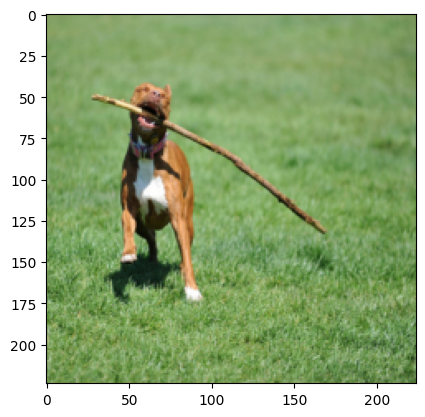

Label : A black and white dog is running through the grass.


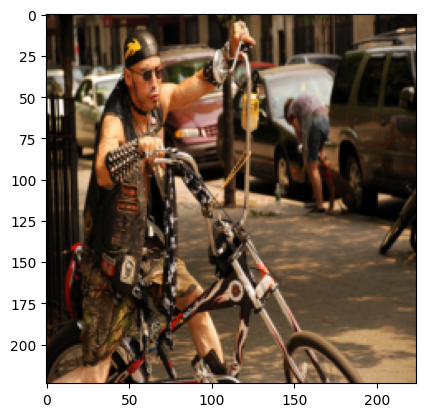

Label : A man in a red shirt and a black shirt is standing in front of a crowd of people.


In [ ]:
images, _, _ = next(iter(val_dataloader))
for image in images[range(7)]:
    image = image.to(device)
    img = tensor_to_image(image)
    caption = generate_caption(image, model, tokenizer)

    plt.imshow(img)
    plt.show()
    print(f"Label : {caption}")

In [ ]:
# Single Image

# images, _, _ = next(iter(val_dataloader))

# image = 'image-name.jpg'
# image = image.to(device)
# img = tensor_to_image(image)
# caption = generate_caption(image, model, tokenizer)

# plt.imshow(img)
# plt.show()
# print(f"Label : {caption}")